# Pretty much manual segmentation
---

#### Overview
Colored serial sections like Christmas cards in Gimp. Now derive bounding box, labels, etc. for each section.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage import io, segmentation, measure
from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from shapely import affinity
from shapely.geometry import polygon, box

from secdetect.utils import neon_cmap

#### Load manual segmentation

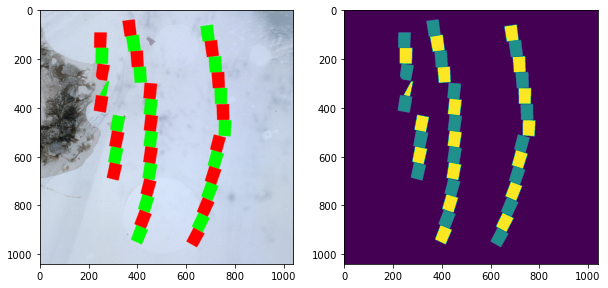

In [4]:
# Filepath to section overview image and mask RGB mask
fp_dir = Path('M:/tnw/ist/do/projects/iCAT/projects/section_detection/20220303_UMCU_RC011/')
fp_image = fp_dir / '20220303_UMCU_RC011.png'
fp_mask = fp_dir / '20220303_UMCU_RC011_mask_rgb.png'
# Load section overview image and mask RGB mask
image = io.imread(fp_image)
mask_rgb = io.imread(fp_mask)

# All non red or green pixels --> black
mask_red = ~(mask_rgb != (255, 0, 0))[:,:,0]
mask_green = ~(mask_rgb != (0, 255, 0))[:,:,0]
mask = mask_red + 2*mask_green

# Create figure
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(mask_rgb)
axes[1].imshow(mask);

#### Complete segmentation

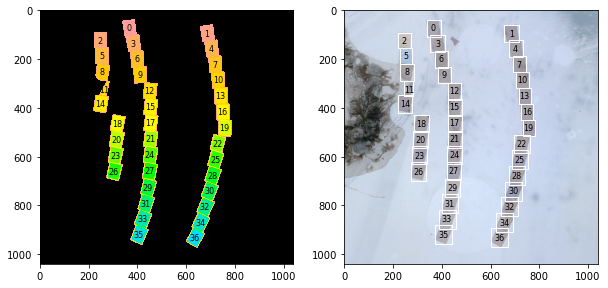

In [5]:
# Label sections
labels = measure.label(mask)

# Create figure
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(labels, cmap=neon_cmap())
axes[1].imshow(image)
# Loop through sections
for i, section in enumerate(measure.regionprops(labels)):
    # Create bbox
    y0, x0, y1, x1 = section.bbox
    p = box(x0, y0, x1, y1)
    # Annotate sections
    axes[1].plot(*p.exterior.xy, color='white', lw=1)
    [ax.text(x=section.centroid[1], y=section.centroid[0],
             s=i, color='black', ha='center', va='center',
             fontsize=8) for ax in axes]

## Section mapping
---

#### Math!

\begin{equation}
    L = Nw - (N - 1) \, o\,w
\end{equation}

\begin{equation}
    N = \text{ceil}\left(\frac{L - o\,w}{w - o\,w}\right)
\end{equation}

In [6]:
from secdetect import find_minimum_bounding_rectangle, generate_tiles

FM HFW....... 217.1µm
EM HFW....... 108.5µm
FM overlap... 25.0%
EM overlap... 150.0%
Rotation..... 9.2°
Dimensions... 412µm x 510µm
Tile grid.... 3 x 3



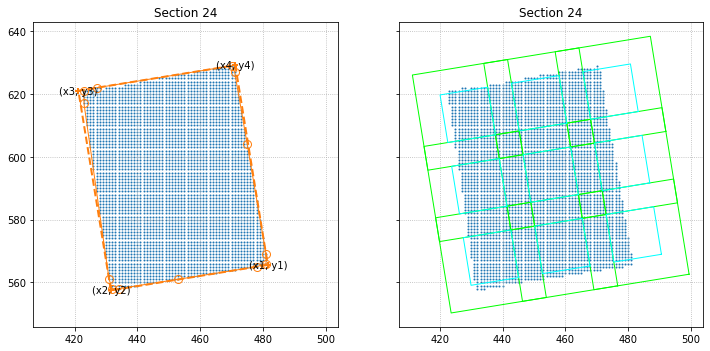

In [7]:
# Tiling parameters
px_FM = 0.106  # nm/px
scale = 0.1415  # px/um
w_FM = px_FM*2048 * scale  # px
o_FM = 0.25  # %
w_EM =  w_FM - 2*o_FM*w_FM
o_EM = (w_FM*(1-o_FM)) / w_EM
offset = w_FM/4

# Choose a random section from the segmented image
sections = measure.regionprops(labels)
# k = np.random.RandomState(35).randint(0, len(sections))
k = np.random.randint(0, len(sections))
section = sections[k]

# Generate tiles
# --------------
tiles_FM, tiles_EM = generate_tiles(section=section,
                                    field_width=w_FM,
                                    overlap=o_FM,
                                    offset=offset,
                                    field_width_subtiles=w_EM)

# Compute convex hull
points = section.coords[:, ::-1]  # row, col --> x, y
hull = ConvexHull(points)
hull_points = points[hull.vertices]

# Minimum bounding rectangle
rect = find_minimum_bounding_rectangle(points)
x1, y1 = rect[0]
x2, y2 = rect[1]
x3, y3 = rect[2]
x4, y4 = rect[3]
rect = np.append(rect, [rect[0,:]], axis=0)  # complete the rectangle

# Calculate rotation
theta = np.arctan2(y2-y3, x2-x3)
theta += np.pi/2 if theta < -np.pi/4 else 0

# Calculate tiling stuff
# ----------------------
if theta >= 0:  # (x1, y1) is bottom right corner
    L = np.sqrt((x1-x2)**2 + (y1-y2)**2) + offset
    H = np.sqrt((x4-x1)**2 + (y4-y1)**2) + offset
else:  # (x1, y1) is top right corner
    L = np.sqrt((x4-x1)**2 + (y4-y1)**2) + offset
    H = np.sqrt((x1-x2)**2 + (y1-y2)**2) + offset
Nx = int(np.ceil((L-o_FM*w_FM)/(w_FM-o_FM*w_FM)))
Ny = int(np.ceil((H-o_FM*w_FM)/(w_FM-o_FM*w_FM)))

# Output
# ------
out = f"""\
FM HFW....... {px_FM*2048:.1f}µm
EM HFW....... {w_EM/scale:.1f}µm
FM overlap... {o_FM:.1%}
EM overlap... {o_EM:.1%}
Rotation..... {theta*180/np.pi:.1f}°
Dimensions... {L/scale:.0f}µm x {H/scale:.0f}µm
Tile grid.... {Nx} x {Ny}
"""; print(out)

# Plots
# -----
fig, axes = plt.subplots(ncols=2, figsize=(12, 6),
                         sharex=True, sharey=True)
# Plot convex hull
axes[0].plot(hull_points[:, 0], hull_points[:, 1], '-o',
             c='C1', mfc='none', lw=1, ms=8)
# Plot minimum bounding rectangle
axes[0].plot(rect[:, 0], rect[:, 1], '+--', mew=2, lw=2, c='C1')
# Plot vertices
for i, point in enumerate([(x1, y1), (x2, y2), (x3, y3), (x4, y4)]):
    axes[0].text(*point, f'(x{i+1}, y{i+1})', ha='center', va='center')
# Plot FM tiles
for tile in tiles_FM:
    axes[1].plot(*tile.exterior.xy, lw=1, color='#00ff00')
# Plot EM tiles
for tile in tiles_EM:
    axes[1].plot(*tile.exterior.xy, lw=1, color='#00ffff')
# Plot sections
for ax in axes:
    ax.plot(points[:, 0], points[:, 1], '.', ms=2, zorder=0)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Section {k}')
    ax.grid(ls=':')